#Import Dependencies

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras import Model

In [5]:
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Input, Concatenate

In [6]:
from tensorflow.keras.utils import plot_model

In [15]:
import glob

In [7]:
from tqdm.notebook import tqdm

In [8]:
import librosa.display

In [9]:
from IPython.display import Audio

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data

In [11]:
!mkdir 'CleanData'
!mkdir 'NoisyData'

In [12]:
!unzip '/content/drive/MyDrive/clean_trainset_wav.zip' -d 'CleanData'

Streaming output truncated to the last 5000 lines.
  inflating: CleanData/p267_421.wav  
  inflating: CleanData/p268_001.wav  
  inflating: CleanData/p268_002.wav  
  inflating: CleanData/p268_003.wav  
  inflating: CleanData/p268_004.wav  
  inflating: CleanData/p268_005.wav  
  inflating: CleanData/p268_006.wav  
  inflating: CleanData/p268_007.wav  
  inflating: CleanData/p268_009.wav  
  inflating: CleanData/p268_010.wav  
  inflating: CleanData/p268_011.wav  
  inflating: CleanData/p268_012.wav  
  inflating: CleanData/p268_013.wav  
  inflating: CleanData/p268_014.wav  
  inflating: CleanData/p268_015.wav  
  inflating: CleanData/p268_016.wav  
  inflating: CleanData/p268_017.wav  
  inflating: CleanData/p268_018.wav  
  inflating: CleanData/p268_019.wav  
  inflating: CleanData/p268_020.wav  
  inflating: CleanData/p268_021.wav  
  inflating: CleanData/p268_022.wav  
  inflating: CleanData/p268_024.wav  
  inflating: CleanData/p268_025.wav  
  inflating: CleanData/p268_026.wav  

In [13]:
!unzip '/content/drive/MyDrive/noisy_trainset_wav.zip' -d 'NoisyData'

Streaming output truncated to the last 5000 lines.
  inflating: NoisyData/p267_421.wav  
  inflating: NoisyData/p268_001.wav  
  inflating: NoisyData/p268_002.wav  
  inflating: NoisyData/p268_003.wav  
  inflating: NoisyData/p268_004.wav  
  inflating: NoisyData/p268_005.wav  
  inflating: NoisyData/p268_006.wav  
  inflating: NoisyData/p268_007.wav  
  inflating: NoisyData/p268_009.wav  
  inflating: NoisyData/p268_010.wav  
  inflating: NoisyData/p268_011.wav  
  inflating: NoisyData/p268_012.wav  
  inflating: NoisyData/p268_013.wav  
  inflating: NoisyData/p268_014.wav  
  inflating: NoisyData/p268_015.wav  
  inflating: NoisyData/p268_016.wav  
  inflating: NoisyData/p268_017.wav  
  inflating: NoisyData/p268_018.wav  
  inflating: NoisyData/p268_019.wav  
  inflating: NoisyData/p268_020.wav  
  inflating: NoisyData/p268_021.wav  
  inflating: NoisyData/p268_022.wav  
  inflating: NoisyData/p268_024.wav  
  inflating: NoisyData/p268_025.wav  
  inflating: NoisyData/p268_026.wav  

In [16]:
#Creating lists of data of clean sound files and noisy sound files

clean_sounds = glob.glob('/content/CleanData/*')
noisy_sounds = glob.glob('/content/NoisyData/*')

clean_sounds_list = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]), desired_channels=1)[0]
for i in tqdm(clean_sounds[1:]):
  s = tf.audio.decode_wav(tf.io.read_file(i), desired_channels=1)[0]
  clean_sounds_list = tf.concat([clean_sounds_list, s], axis=0)

noisy_sounds_list = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]), desired_channels=1)[0]
for i in tqdm(noisy_sounds[1:]):
  s = tf.audio.decode_wav(tf.io.read_file(i), desired_channels=1)[0]
  noisy_sounds_list = tf.concat([noisy_sounds_list, s], axis=0)

print(clean_sounds_list.shape)
print(noisy_sounds_list.shape)

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(540938091, 1)
(540938091, 1)


In [23]:
c = clean_sounds_list[:]
n = noisy_sounds_list[:]

In [43]:
#This was done because data size was too big leading to ResourceExhaustedError in next cell
clean_sounds_list = c[::6]
noisy_sounds_list = n[::6]

print(clean_sounds_list.shape)
print(noisy_sounds_list.shape)

(90156349, 1)
(90156349, 1)


In [44]:
#Splitting the above lists into batches of 12000 for tflite purposes

BATCH_SIZE = 12000

clean_train, noisy_train = [], []

for i in tqdm(range(0, clean_sounds_list.shape[0]-BATCH_SIZE, BATCH_SIZE)):
  clean_train.append(clean_sounds_list[i:i+BATCH_SIZE])
  noisy_train.append(noisy_sounds_list[i:i+BATCH_SIZE])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

print(clean_train.shape)
print(noisy_train.shape)

  0%|          | 0/7513 [00:00<?, ?it/s]

(7513, 12000, 1)
(7513, 12000, 1)


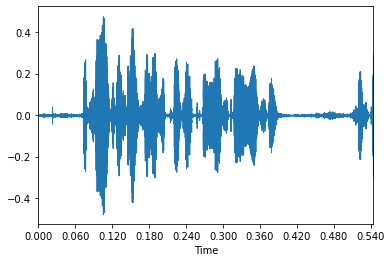

In [45]:
#Visualizing clean sound waveform
librosa.display.waveplot(np.squeeze(clean_train[0].numpy(), axis=-1))
plt.show()

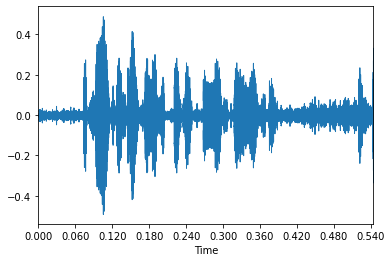

In [46]:
#Visualizing noisy sound waveform
librosa.display.waveplot(np.squeeze(noisy_train[0].numpy(), axis=-1))
plt.show()

In [47]:
#Creating training and testing datasets from data
def get_dataset(X_train, y_train):
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  dataset = dataset.shuffle(100).batch(64, drop_remainder=True)
  return dataset

In [48]:
train_dataset = get_dataset(noisy_train[:7400], clean_train[:7400])
test_dataset = get_dataset(noisy_train[7400:], clean_train[7400:])

#Model

In [49]:
#Creating the model
input = Input(shape=(BATCH_SIZE,1))

c1 = Conv1D(filters=2, kernel_size=32, strides=2, padding='same', activation='relu')(input)
c2 = Conv1D(filters=4, kernel_size=32, strides=2, padding='same', activation='relu')(c1)
c3 = Conv1D(filters=8, kernel_size=32, strides=2, padding='same', activation='relu')(c2)
c4 = Conv1D(filters=16, kernel_size=32, strides=2, padding='same', activation='relu')(c3)
c5 = Conv1D(filters=32, kernel_size=32, strides=2, padding='same', activation='relu')(c4)

dc1 = Conv1DTranspose(filters=32, kernel_size=32, strides=1, padding='same')(c5)
conc = Concatenate()([c5, dc1])

dc2 = Conv1DTranspose(filters=16, kernel_size=32, strides=2, padding='same')(conc)
conc = Concatenate()([c4, dc2])

dc3 = Conv1DTranspose(filters=8, kernel_size=32, strides=2, padding='same')(conc)
conc = Concatenate()([c3, dc3])

dc4 = Conv1DTranspose(filters=4, kernel_size=32, strides=2, padding='same')(conc)
conc = Concatenate()([c2, dc4])

dc5 = Conv1DTranspose(filters=2, kernel_size=32, strides=2, padding='same')(conc)
conc = Concatenate()([c1, dc5])

dc6 = Conv1DTranspose(filters=1, kernel_size=32, strides=2, padding='same')(conc)
conc = Concatenate()([input, dc6])

dc7 = Conv1DTranspose(filters=1, kernel_size=32, strides=1, padding='same')(conc)

model = Model(inputs=input, outputs=dc7)

In [50]:
#Summarize the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 6000, 2)      66          ['input_6[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 3000, 4)      260         ['conv1d_9[0][0]']               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 1500, 8)      1032        ['conv1d_10[0][0]']              
                                                                                            

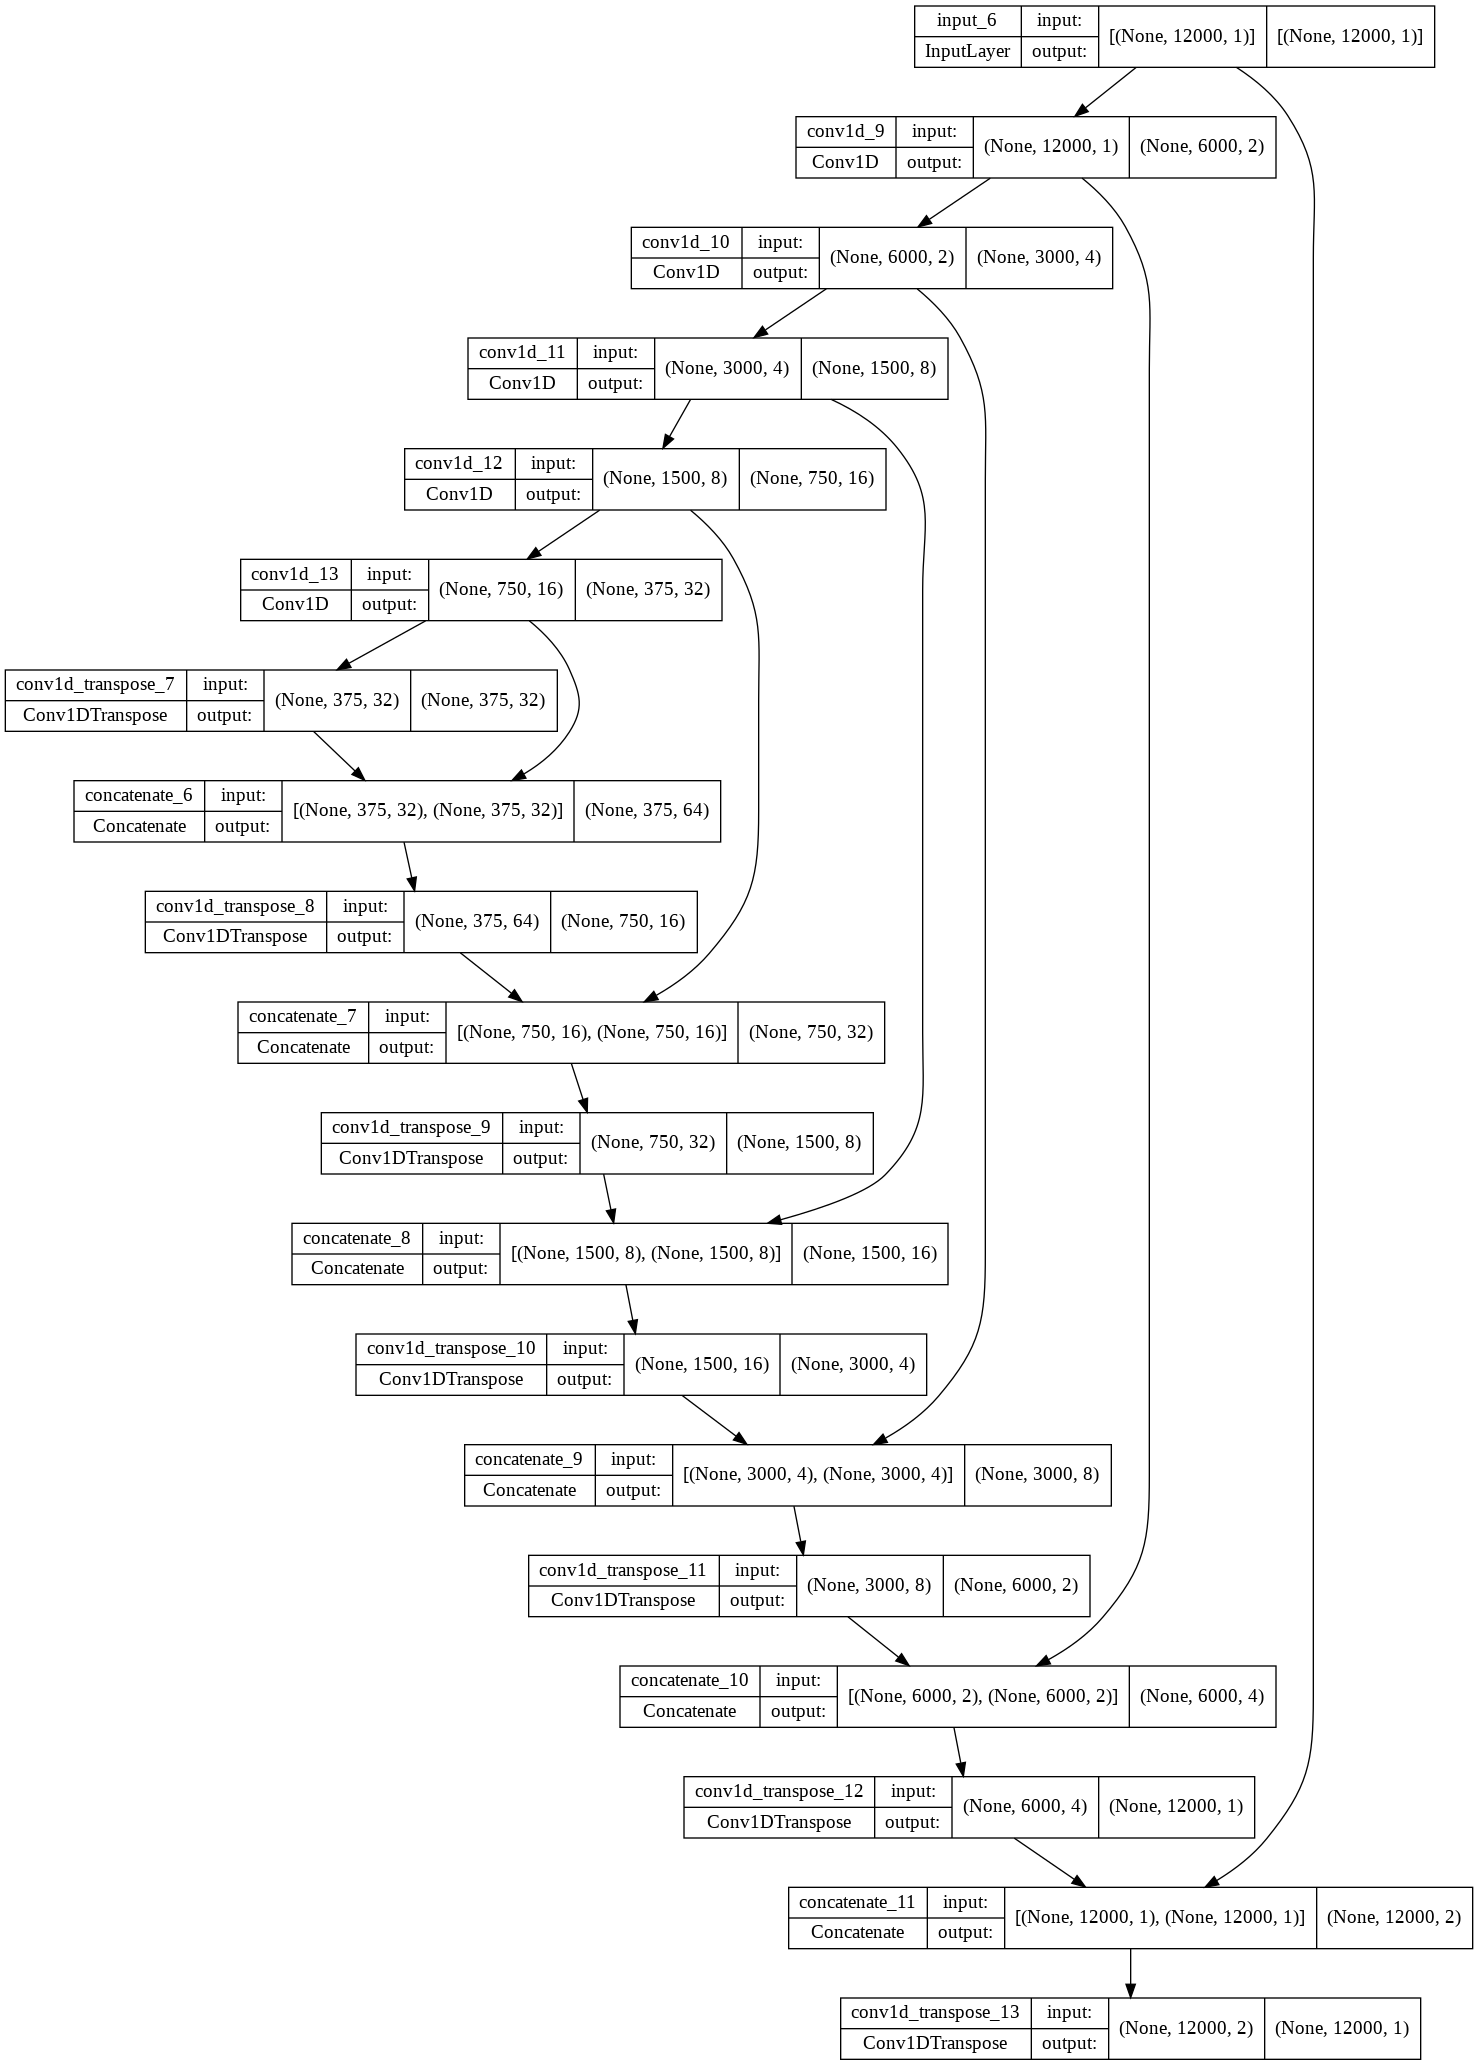

In [51]:
#Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

#Training

In [52]:
#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['accuracy'])

In [53]:
#Fit the model
history = model.fit(train_dataset, epochs=20)

Epoch 1/20
115/115 [==============================] - 5s 36ms/step - loss: 0.0305 - accuracy: 0.0015
Epoch 2/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0212 - accuracy: 0.0015
Epoch 3/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0187 - accuracy: 0.0015
Epoch 4/20
115/115 [==============================] - 4s 37ms/step - loss: 0.0179 - accuracy: 0.0015
Epoch 5/20
115/115 [==============================] - 4s 37ms/step - loss: 0.0174 - accuracy: 0.0015
Epoch 6/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0172 - accuracy: 0.0015
Epoch 7/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0170 - accuracy: 0.0015
Epoch 8/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0168 - accuracy: 0.0015
Epoch 9/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0166 - accuracy: 0.0015
Epoch 10/20
115/115 [==============================] - 4s 36ms/step - loss: 0.0165 - accura

#Testing

In [79]:
Audio(np.squeeze(noisy_train[4].numpy()), rate=16000)

In [73]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[4], axis=-1), axis=0))), rate=16000)

In [74]:
Audio(np.squeeze(clean_train[4].numpy()), rate=16000)

In [60]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 372ms/step - loss: 0.0164 - accuracy: 0.0013


[0.016405006870627403, 0.0013085937825962901]

In [64]:
model.save('NoiseSuppressionModel.h5')

#Inference

Different sized audio inputs can be hanled by overlapping prediction frames at the end, and then removing the intersection part from the final waveform

In [65]:
def get_audio(path):
  audio = tf.audio.decode_wav(tf.io.read_file(path), desired_channels=1)[0]
  return audio

In [66]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0, audio_len-BATCH_SIZE, BATCH_SIZE):
    batches.append(audio[i:i+BATCH_SIZE])
    diff = audio_len - (i+BATCH_SIZE)   #remaining waveform length
  batches.append(audio[-BATCH_SIZE:])
  return tf.stack(batches), diff

In [67]:
def predict(path):
  test_data, diff = inference_preprocess(path)
  prediction = model.predict(test_data)
  final_op = tf.reshape(prediction[:-1],((prediction.shape[0]-1)*prediction.shape[1],1))
  final_op = tf.concat((final_op, prediction[-1][-diff:]), axis=0)
  return final_op

In [69]:
Audio(np.squeeze(get_audio(noisy_sounds[2000]).numpy(), axis=-1),rate=16000)

In [71]:
Audio(tf.squeeze(predict(noisy_sounds[2000])),rate=16000)

In [91]:
Audio(tf.squeeze(predict(clean_sounds[2000])),rate=16000)

In [75]:
%%timeit
tf.squeeze(predict(noisy_sounds[2000]))

10 loops, best of 5: 46.2 ms per loop


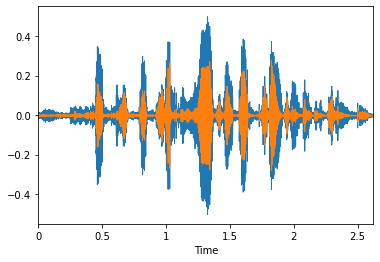

In [90]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[2000]).numpy(), axis=-1))
#librosa.display.waveplot(np.squeeze(get_audio(clean_sounds[2000]).numpy(), axis=-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[2000])))